<a href="https://colab.research.google.com/github/lahoffman/ml_tutorial/blob/main/nn_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Set up Environments

In [ ]:
#system
import sys
import numpy as np
import seaborn as sb
import xarray as xr
import h5py

#plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
!pip install "basemap == 1.3.0b1" "basemap-data == 1.3.0b1"
from mpl_toolkits.basemap import Basemap
!pip install cmocean
import cmocean

#machine learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras import backend as K
import keras.utils
import sklearn
from sklearn.model_selection import train_test_split
from scipy import stats, odr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.4/880.4 KB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.6/219.6 KB 9.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyshp: filename=pyshp-2.1.3-py3-none-any.whl size=37324 sha256=48c54806a06f338f6a3bb784c9a399761a2df6c1fb0950d8cec01109f399edf3
  Stored in directory: /root/.cache/pip/wheels/1f/1b/b5/54affbefc8a7e2bdf1da000fc576b8a1c91338f1f327a04f4c
Successfully built pyshp
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling num

In [ ]:
print(f"python version = {sys.version}")
print(f"numpy version = {np.__version__}")
print(f"tensorflow version = {tf.__version__}")  

python version = 3.8.10 (default, Nov 14 2022, 12:59:47) 
[GCC 9.4.0]
numpy version = 1.22.4
tensorflow version = 2.11.0


# 1. Data Preparation

## 1.1 Data Download

In [ ]:
#allow access to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#import dataset
df = h5py.File('/content/drive/MyDrive/Colab Notebooks/data/ALL_ITP_DATA.mat','r')

In [ ]:
#variables
ui = np.array(df['fullData'][0,:]) #u-ice velocity
vi = np.array(df['fullData'][1,:]) #v-ice velocity
ua = np.array(df['fullData'][2,:]) #u-wind
va = np.array(df['fullData'][3,:]) #v-wind
ci = np.array(df['fullData'][4,:]) #ice concentration
lonitp = np.array(df['fullData'][5,:]) #longitude
latitp = np.array(df['fullData'][6,:]) #latitude
doy = np.array(df['fullData'][7,:]) #day of year
itp = np.array(df['fullData'][8,:]) #itp number
icespeed = np.sqrt(np.square(ui) + np.square(vi))
windspeed = np.sqrt(np.square(ua) + np.square(va))

## 1.2 Data Visualization

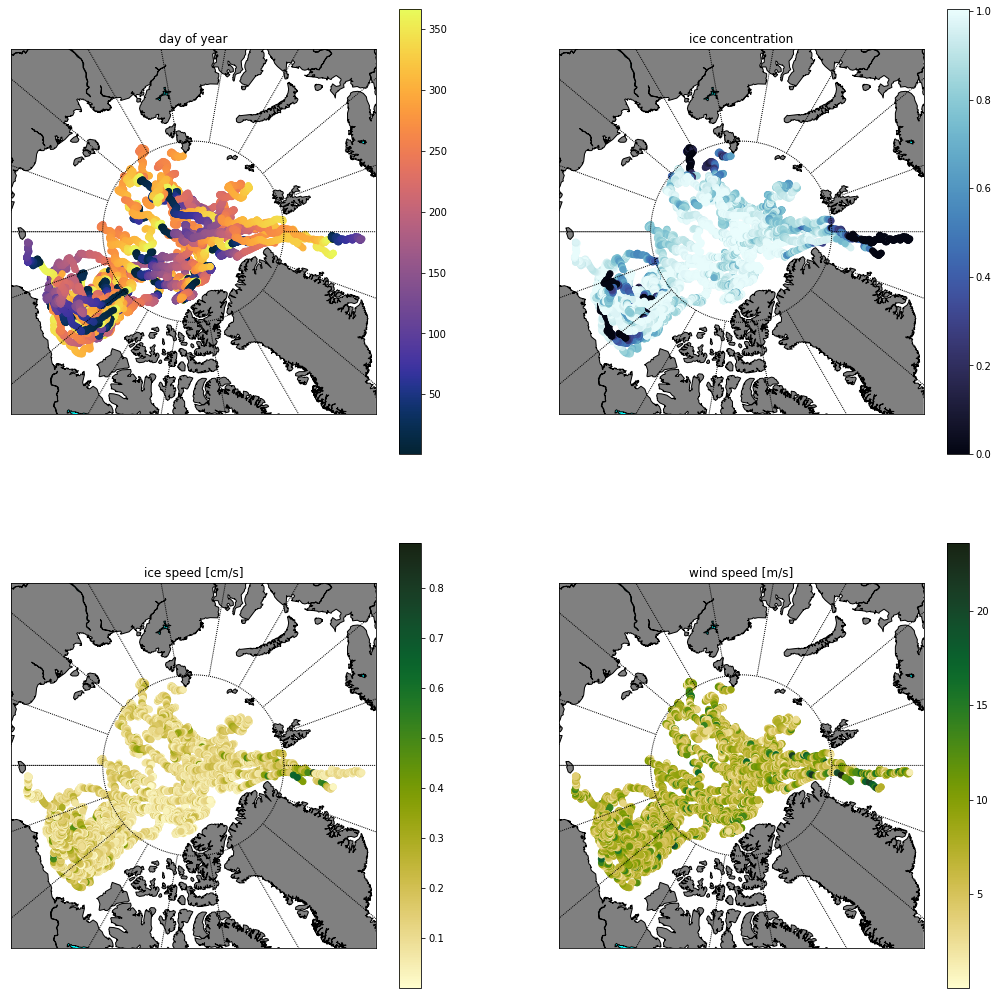

In [ ]:
#maps
fig = plt.figure(figsize=(18,18))

#day of year
ax = fig.add_subplot(221)
ax.set_title('day of year')
# north polar stereographic basemap.
m = Basemap(projection='npstere',boundinglat=70,lon_0=270,resolution='l')
m.drawcoastlines()
m.fillcontinents(color='gray',lake_color='aqua')
# draw parallels and meridians.
m.drawparallels(np.arange(-80.,81.,20.))
m.drawmeridians(np.arange(-180.,181.,20.))
x, y = m(lonitp, latitp)
plt.scatter(x,y,c=doy,cmap=cmocean.cm.thermal)
plt.colorbar()

#ice concentration
ax = fig.add_subplot(222)
ax.set_title('ice concentration')
# north polar stereographic basemap.
m = Basemap(projection='npstere',boundinglat=70,lon_0=270,resolution='l')
m.drawcoastlines()
m.fillcontinents(color='gray',lake_color='aqua')
# draw parallels and meridians.
m.drawparallels(np.arange(-80.,81.,20.))
m.drawmeridians(np.arange(-180.,181.,20.))
x, y = m(lonitp, latitp)
plt.scatter(x,y,c=ci,cmap=cmocean.cm.ice)
plt.colorbar()

#ice speed
ax = fig.add_subplot(223)
ax.set_title('ice speed [cm/s]')
# north polar stereographic basemap.
m = Basemap(projection='npstere',boundinglat=70,lon_0=270,resolution='l')
m.drawcoastlines()
m.fillcontinents(color='gray',lake_color='aqua')
# draw parallels and meridians.
m.drawparallels(np.arange(-80.,81.,20.))
m.drawmeridians(np.arange(-180.,181.,20.))
x, y = m(lonitp, latitp)
plt.scatter(x,y,c=icespeed,cmap=cmocean.cm.speed)
plt.colorbar()

#wind speed
ax = fig.add_subplot(224)
ax.set_title('wind speed [m/s]')
# north polar stereographic basemap.
m = Basemap(projection='npstere',boundinglat=70,lon_0=270,resolution='l')
m.drawcoastlines()
m.fillcontinents(color='gray',lake_color='aqua')
# draw parallels and meridians.
m.drawparallels(np.arange(-80.,81.,20.))
m.drawmeridians(np.arange(-180.,181.,20.))
x, y = m(lonitp, latitp)
plt.scatter(x,y,c=windspeed,cmap=cmocean.cm.speed)
plt.colorbar()

plt.show()

Text(0, 0.5, 'ice concentration')

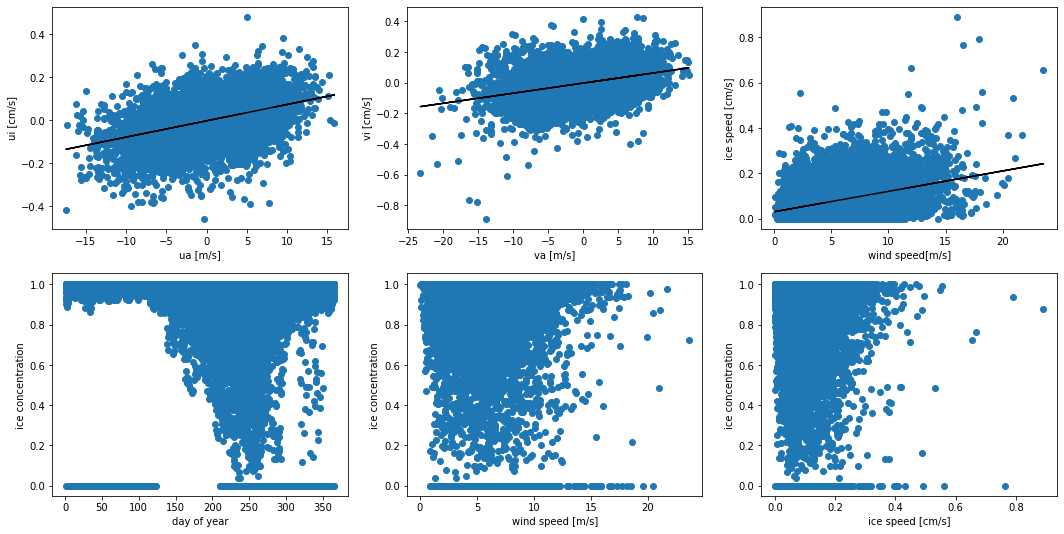

In [ ]:
from scipy import stats, odr

#scatter: compare variables
fig, axs = plt.subplots(2, 3,figsize=(18,9))
axs[0,0].scatter(ua,ui)
axs[0,0].set_xlabel('ua [m/s]')
axs[0,0].set_ylabel('ui [cm/s]')
slope, intercept, r_value, p_value, std_err = stats.linregress(np.squeeze(ua),np.squeeze(ui))
axs[0,0].plot(ua,intercept+ua*slope,'-',color = 'black', label = 'LSQ: x vs y')

axs[0,1].scatter(va,vi)
axs[0,1].set_xlabel('va [m/s]')
axs[0,1].set_ylabel('vi [cm/s]')
slope, intercept, r_value, p_value, std_err = stats.linregress(np.squeeze(va),np.squeeze(vi))
axs[0,1].plot(va,intercept+va*slope,'-',color = 'black', label = 'LSQ: x vs y')

axs[0,2].scatter(windspeed,icespeed)
axs[0,2].set_xlabel('wind speed[m/s]')
axs[0,2].set_ylabel('ice speed [cm/s]')
slope, intercept, r_value, p_value, std_err = stats.linregress(np.squeeze(windspeed),np.squeeze(icespeed))
axs[0,2].plot(windspeed,intercept+windspeed*slope,'-',color = 'black', label = 'LSQ: x vs y')

axs[1,0].scatter(doy,ci)
axs[1,0].set_xlabel('day of year')
axs[1,0].set_ylabel('ice concentration')

axs[1,1].scatter(windspeed,ci)
axs[1,1].set_xlabel('wind speed [m/s]')
axs[1,1].set_ylabel('ice concentration')

axs[1,2].scatter(icespeed,ci)
axs[1,2].set_xlabel('ice speed [cm/s]')
axs[1,2].set_ylabel('ice concentration')

## 1.3 Processing Data for ML

### 1.3.1 Feature Scaling

#### Why do we apply Feature Scaling?
Features (or variables) that are input to a ML model may have vastly different ranges, which might cause a ML model to put more weights on variables with a larger range. Feature Scaling (either standardization or normalization) makes it so features are on similar scales.

***Standardization:*** Here, data is standardized to zero mean and one standard deviation (i.e. subtract mean and divide by standard deviation).

In [ ]:
#standardize data
uas = (ua-np.mean(ua))/np.std(ua)
vas = (va-np.mean(va))/np.std(va)
uis = (ui-np.mean(ui))/np.std(ui)
vis = (vi-np.mean(vi))/np.std(vi)
cis = (ci-np.mean(ci))/np.std(ci)
lats = (latitp-np.mean(latitp))/np.std(latitp)
lons = (lonitp-np.mean(lonitp))/np.std(lonitp)
doys = (doy-np.mean(doy))/np.std(doy)

### 1.3.2 Feature Exploration


In [ ]:
#specify variables

n = 1
nn = n+1

#present-day [variables at day 0]
ui0 = uis[n:-1]
vi0 = vis[n:-1]
ua0 = uas[n:-1]
va0 = vas[n:-1]
ci0 = cis[n:-1]
lon0 = lons[n:-1]
lat0 = lats[n:-1]
doy0 = doys[n:-1]

#previous-day: vatiables at day 0-n
uin = uis[0:-nn]
vin = vis[0:-nn]
uan = uas[0:-nn]
van = vas[0:-nn]
cin = cis[0:-nn]
lonn = lons[0:-nn]
latn = lats[0:-nn]
doyn = doys[0:-nn]


print('uis:', uis.shape)
print('uio:', ui0.shape)
print('uin:', uin.shape)

uis: (17130,)
uio: (17128,)
uin: (17128,)


In [ ]:
#concatenate desired inputs into x & y
x = np.stack((ua0,va0,uin,vin,cin,lat0,lon0),axis=1)

y = np.stack((ui0,vi0),axis=1)

xt (15414, 7)
yt (15414, 2)
xte (1713, 7)
yte (1713, 2)


### 1.3.3 Partitioning Data in Training, Validation, and Test Datasets

Data are split into train, validate, and test sets before entered into a ML model, typically with an 80% - 10% - 10% split.

***Train:***  Training data is used to fit the model.

***Validate:*** The validation dataset is used to evaluate the model fit during training and update the model hyperparameters.

***Test:*** The test dataset is not seen by the model during training and use used to provide an unbias evaluation of the final model fit.


In [ ]:
#test set
xte = x[0:1713,:]
yte = y[0:1713,:]

#train and validate set
xt = x[1713:-1,:]
yt = y[1713:-1,:]

print('xt',xt.shape)
print('yt',yt.shape)

print('xte',xte.shape)
print('yte',yte.shape)

#split train and validate
x_train, x_val, y_train, y_val = train_test_split(xt,yt,test_size = .1, shuffle=True, random_state = 12)

# 2. Neural Network

## 2.1 Define Custom Metrics and Loss Functions

What is a loss function?

In [ ]:
#define NRMSE function
def norm_root_mean_squared_error(y_true,y_pred):
    return  (K.sqrt(K.mean(K.square(y_pred - y_true))))/((K.std(y_true)))

#define pearson correlation 
def tf_pearson(y_true, y_pred):
    return (K.sum((y_true-K.mean(y_true))*(y_pred-K.mean(y_pred))))/((K.sqrt(K.sum(K.square(y_true-K.mean(y_true)))))*(K.sqrt(K.sum(K.square(y_pred-K.mean(y_pred))))))

## 2.2 Define Model Hyperparameters

In [ ]:
# Here are some model hyperparameters we can edit


# LOSS FUNCTION
LOSS = norm_root_mean_squared_error # Loss Function used
METRIC = tf_pearson # Metric for assessing model skill

# MODEL TRAINING
NUM_EPOCHS = 20 # Max number of times all of the data will be seen iteratively in training
BATCH_SIZE = 365 # Number of samples
LEARNING_RATE = .1 # Learning rate (think step size)
DROP = 0.2



## 2.3 Building a Neural Network

### 2.3.1 Linear Model

Complie and train the model

Epoch 1/50
39/39 [==============================] - 1s 13ms/step - loss: 1.6014 - accuracy: 0.5040 - tf_pearson: -0.2965 - val_loss: 1.5976 - val_accuracy: 0.5240 - val_tf_pearson: -0.2873
Epoch 2/50
39/39 [==============================] - 0s 4ms/step - loss: 1.5284 - accuracy: 0.5163 - tf_pearson: -0.2841 - val_loss: 1.5228 - val_accuracy: 0.5357 - val_tf_pearson: -0.2579
Epoch 3/50
39/39 [==============================] - 0s 5ms/step - loss: 1.4579 - accuracy: 0.5287 - tf_pearson: -0.2156 - val_loss: 1.4518 - val_accuracy: 0.5441 - val_tf_pearson: -0.2240
Epoch 4/50
39/39 [==============================] - 0s 5ms/step - loss: 1.3932 - accuracy: 0.5409 - tf_pearson: -0.1916 - val_loss: 1.3854 - val_accuracy: 0.5571 - val_tf_pearson: -0.1832
Epoch 5/50
39/39 [==============================] - 0s 4ms/step - loss: 1.3297 - accuracy: 0.5581 - tf_pearson: -0.1288 - val_loss: 1.3215 - val_accuracy: 0.5830 - val_tf_pearson: -0.1349
Epoch 6/50
39/39 [==============================] - 0s 5ms/

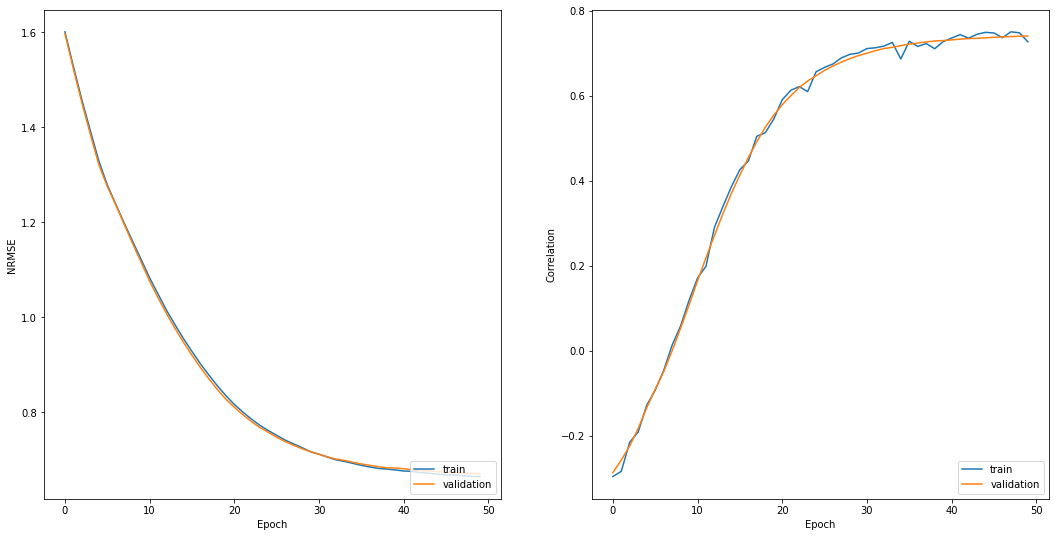

In [ ]:
# Example: build a fully-connected network

# In Keras a NN model is built in layers
# Most common type is sequential layers - one layer after the other with 
# connections only between neighboring layers.

#hyperparameters
[nd,nc] = y_train.shape
NUM_EPOCHS = 50

# define the model: linear model with one layer
model = tf.keras.Sequential()
model.add(layers.Dense(nc,activation='linear'))

#compile and train model
model.compile(optimizer='adam',loss=LOSS ,metrics=['accuracy',METRIC])

# train the model
history = model.fit(x_train,y_train,epochs=NUM_EPOCHS,batch_size=BATCH_SIZE,shuffle=True,validation_data=(x_val,y_val))
print(history)
print(model.summary())

#evaluate model: plot the loss during training 
plot1 = plt.figure(1,figsize=(18,9))
plt.subplot(1,2,1)
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='validation')
plt.xlabel('Epoch')
plt.ylabel('NRMSE')
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(history.history['tf_pearson'],label='train')
plt.plot(history.history['val_tf_pearson'],label='validation')
plt.xlabel('Epoch')
plt.ylabel('Correlation')
plt.legend(loc='lower right')
plt.show()

Evaluate and Visualize Model Predictions

54/54 [==============================] - 0s 2ms/step
(1713, 2)


Text(0, 0.5, 'predicted value')

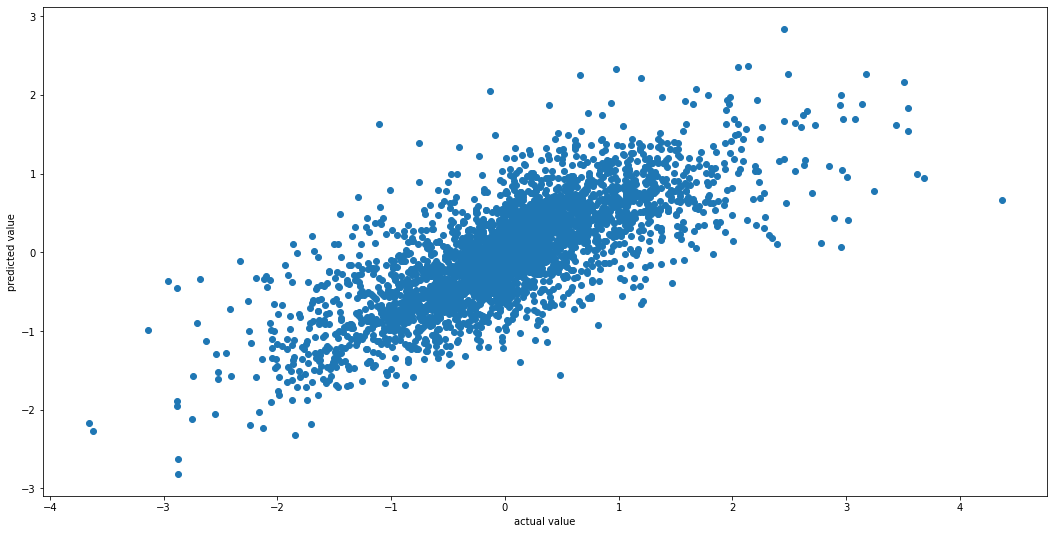

In [ ]:
#make predictions using the test dataset
# make predictions with your model using the test dataset
y_true = yte
y_pred = model.predict(xte)

print(y_pred.shape)

plt.figure(figsize=(18,9))
plt.scatter(y_true,y_pred)
plt.xlabel('actual value')
plt.ylabel('predicted value')

### 2.3.2 Deep NN w/ hidden layers

Compile and train the model

Epoch 1/20
39/39 [==============================] - 1s 9ms/step - loss: 0.9698 - accuracy: 0.5675 - tf_pearson: 0.2565 - val_loss: 0.8865 - val_accuracy: 0.7017 - val_tf_pearson: 0.4760
Epoch 2/20
39/39 [==============================] - 0s 4ms/step - loss: 0.8114 - accuracy: 0.7303 - tf_pearson: 0.6046 - val_loss: 0.7754 - val_accuracy: 0.7471 - val_tf_pearson: 0.6364
Epoch 3/20
39/39 [==============================] - 0s 4ms/step - loss: 0.7277 - accuracy: 0.7603 - tf_pearson: 0.6982 - val_loss: 0.7226 - val_accuracy: 0.7607 - val_tf_pearson: 0.6925
Epoch 4/20
39/39 [==============================] - 0s 3ms/step - loss: 0.6904 - accuracy: 0.7651 - tf_pearson: 0.7145 - val_loss: 0.6989 - val_accuracy: 0.7620 - val_tf_pearson: 0.7175
Epoch 5/20
39/39 [==============================] - 0s 4ms/step - loss: 0.6761 - accuracy: 0.7687 - tf_pearson: 0.7361 - val_loss: 0.6858 - val_accuracy: 0.7672 - val_tf_pearson: 0.7289
Epoch 6/20
39/39 [==============================] - 0s 3ms/step - loss

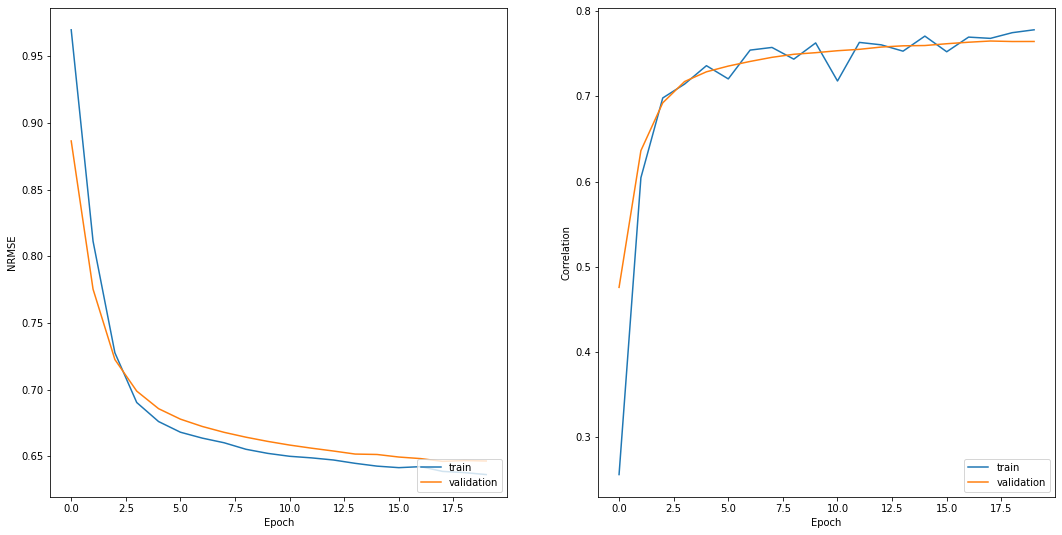

In [ ]:
# Example: build a fully-connected network

# In Keras a NN model is built in layers
# Most common type is sequential layers - one layer after the other with 
# connections only between neighboring layers.

#
[nd,nc] = y_train.shape
n_units = 16

# define the model
model = tf.keras.Sequential()
model.add(layers.Dense(n_units,activation='relu'))
model.add(layers.Dense(n_units,activation='relu'))
model.add(layers.Dense(nc,activation=None))

#compile and train model
model.compile(optimizer='adam',loss=LOSS ,metrics=['accuracy',METRIC])

# train the model
history = model.fit(x_train,y_train,epochs=NUM_EPOCHS,batch_size=BATCH_SIZE,shuffle=True,validation_data=(x_val,y_val))
print(history)
print(model.summary())

#evaluate model: plot the loss during training 
plot1 = plt.figure(1,figsize=(18,9))
plt.subplot(1,2,1)
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='validation')
plt.xlabel('Epoch')
plt.ylabel('NRMSE')
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(history.history['tf_pearson'],label='train')
plt.plot(history.history['val_tf_pearson'],label='validation')
plt.xlabel('Epoch')
plt.ylabel('Correlation')
plt.legend(loc='lower right')
plt.show()


Evaluate and Visualize Model Predictions

54/54 [==============================] - 0s 6ms/step
ypred: (1713, 2)
ytrue: (1713, 2)


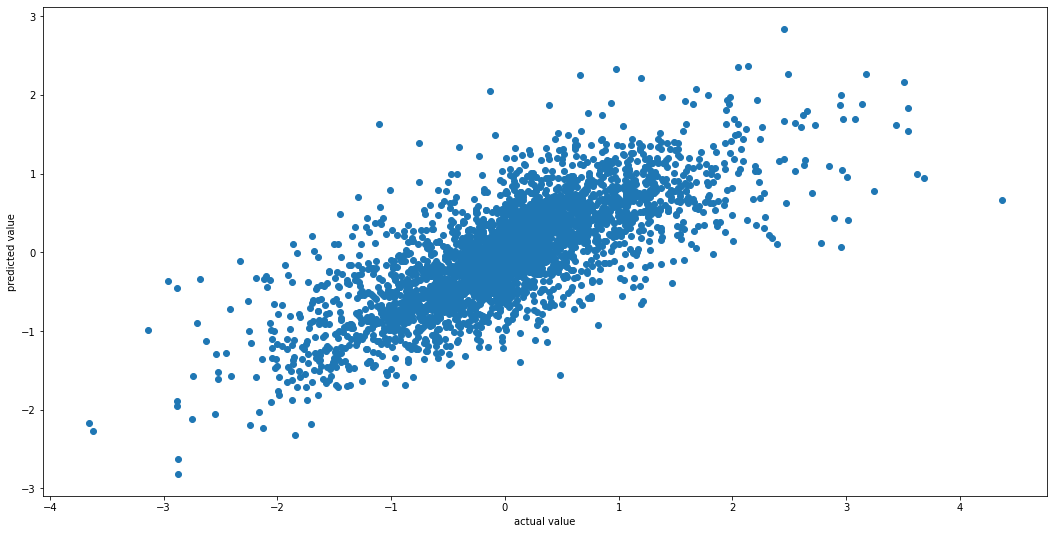

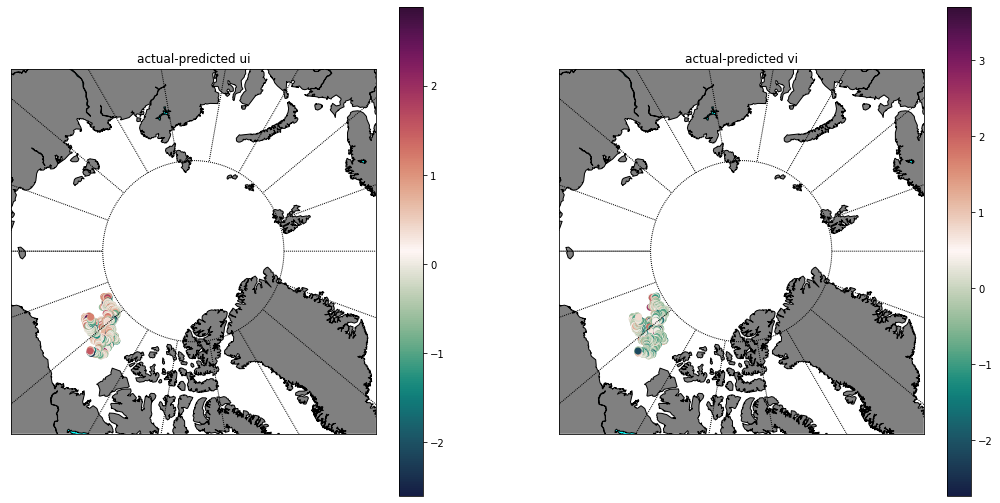

In [ ]:
# make predictions with your model using the test dataset
y_true = yte
y_pred = model.predict(xte)

print('ypred:', y_pred.shape)
print('ytrue:', y_true.shape)

plt.figure(figsize=(18,9))
plt.scatter(y_true,y_pred)
plt.xlabel('actual value')
plt.ylabel('predicted value')

#RMS DIFF CONCATENATE
vdiff = y_true[:,1]-y_pred[:,1]
udiff = y_true[:,0]-y_pred[:,0]

#maps
fig = plt.figure(figsize=(18,9))

#day of year
ax = fig.add_subplot(121)
ax.set_title('actual-predicted ui')
# north polar stereographic basemap.
m = Basemap(projection='npstere',boundinglat=70,lon_0=270,resolution='l')
m.drawcoastlines()
m.fillcontinents(color='gray',lake_color='aqua')
# draw parallels and meridians.
m.drawparallels(np.arange(-80.,81.,20.))
m.drawmeridians(np.arange(-180.,181.,20.))
x, y = m(lonitp[0:1713], latitp[0:1713])
plt.scatter(x,y,c=udiff,cmap=cmocean.cm.curl)
plt.colorbar()

#ice concentration
ax = fig.add_subplot(122)
ax.set_title('actual-predicted vi')
# north polar stereographic basemap.
m = Basemap(projection='npstere',boundinglat=70,lon_0=270,resolution='l')
m.drawcoastlines()
m.fillcontinents(color='gray',lake_color='aqua')
# draw parallels and meridians.
m.drawparallels(np.arange(-80.,81.,20.))
m.drawmeridians(np.arange(-180.,181.,20.))
x, y = m(lonitp[0:1713], latitp[0:1713])
plt.scatter(x,y,c=vdiff,cmap=cmocean.cm.curl)
plt.colorbar()
